In [1]:
import os, copy, pickle, torch, torchvision, types
import types
from torch import Tensor
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split

import numpy as np
from tqdm import tqdm

from utils import AverageMeter, accuracy, save_checkpoint, plot_train_progress, get_model
from loss import LossComputer

from data.dro_dataset import get_loader

In [35]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
from typing import Any, Callable, List, Optional, Type, Union
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class FeatResNet(nn.Module):
    
    def __init__(self, core_resnet, level):
        super(FeatResNet, self).__init__()
        self.internal = core_resnet
        self.level = level
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.internal.conv1(x)
        x = self.internal.bn1(x)
        x = self.internal.relu(x)
        x = self.internal.maxpool(x)

        x = self.internal.layer1(x)
        if self.level == 1: return x
        
        x = self.internal.layer2(x)
        if self.level == 2: return x
        
        x = self.internal.layer3(x)
        if self.level == 3: return x
        
        x = self.internal.layer4(x)
        if self.level == 4: return x

        x = self.internal.avgpool(x)
        x = torch.flatten(x, 1)
        ft = x
        x = self.internal.fc(x)

        return x

class Projector(nn.Module):
    def __init__(self, d, conv_block=None):
        super(Projector, self).__init__()
        self.block = conv_block
        self.fc = nn.Linear(d, 2)

    def forward(self, x):
        if self.block != None:
            x = self.block(x)
        x = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(x), 1)
        x = self.fc(x)
        return x

In [18]:
# train
def train(model, projector, optimizer, train_loader, num_epochs=8):
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    model.eval()
    projector.train()
    for epoch in range(num_epochs):
#         print(epoch)
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device='cuda')
            y = batch[1].to(device='cuda')
            yhat = projector(model(x))
            loss = criterion(yhat, y).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def infer(model, projector, test_loader, widx=2):
    model.eval()
    projector.eval()
    
    pred_probs_list = []
    correct_pred_list = []
    worst_collect_list = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            x = batch[0].to(device='cuda')
            y = batch[1]
            g = batch[2]
            yhat = torch.softmax(projector(model(x)), dim=1).to(device='cpu')
            top_preds = torch.argmax(yhat, dim=1)
            correct = top_preds == y
            worst_flag = g == widx
            
            pred_probs_list.append(yhat)
            correct_pred_list.append(correct)
            worst_collect_list.append(worst_flag)
    
    pred_probs = torch.cat(pred_probs_list, dim=0)
    correct_preds = torch.cat(correct_pred_list, dim=0)
    worst_collect = torch.cat(worst_collect_list, dim=0)
    return pred_probs, correct_preds, worst_collect

In [43]:
def get_margin_hist(dataset, epoch, feature_level, basic_block=False):
    torch.manual_seed(0)
    if dataset == 'CelebA': 
        learning_rate = 1e-4
        widx = 3
        epochs = 1
        pkl_name = 'Blond_Hair_Male_dataset_0.pkl'
    else: # could be named waterbirds
        dataset = 'CUB'
        learning_rate = 1e-3
        widx = 2
        epochs = 8 # change
        pkl_name = 'waterbird_complete95_forest2water2_dataset_0.pkl'
    
    loader_kwargs = {'batch_size':10, 'num_workers':4, 'pin_memory':True}
    with open(os.path.join('results', dataset, pkl_name), 'rb') as file:
        data = pickle.load(file)
        train_data = data['train_data']
        train_loader = get_loader(train_data, train=True, **loader_kwargs)
    loader_kwargs = {'batch_size':128, 'num_workers':4, 'pin_memory':True}
    n = len(train_data)
    train_data, test_data = random_split(train_data, [n//2, n-n//2])
    train_loader, test_loader = get_loader(train_data, train=True, **loader_kwargs), get_loader(test_data, train=False, **loader_kwargs)
    
    model = get_model('resnet18')
    d = model.fc.in_features
    model.fc = nn.Linear(d, 2)
    model_ckpt = torch.load(os.path.join(f'./results/{dataset}/resnet18-pt_0/', f'{epoch}_ckpt.pth.tar'))
    model.load_state_dict(model_ckpt['model'])
        
    model = model.to(device='cuda')
    for _, param in model.named_parameters():
        param.requires_grad = False
    model = FeatResNet(model, feature_level).to(device='cuda')
    
    samples = next(iter(train_loader))
    sample_inputs = samples[0].to(device='cuda')
    
    if basic_block:
        converter = BasicBlock(32 * 2**feature_level, 64 * 2**feature_level, stride=1).to(device='cuda')
        features = converter(model(sample_inputs))
        d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
        projector = Projector(d, converter).to(device='cuda')
        projector.train()
    else:
        features = model(sample_inputs)
        d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
        projector = Projector(d).to(device='cuda')
        projector.train()
    
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, projector.parameters()), 
                                lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    train(model, projector, optimizer, train_loader, num_epochs=epochs)

    yhat, correct, worst = infer(model, projector, test_loader, widx=widx)
    confident = torch.abs(yhat[:, 0] - yhat[:, 1])
    
    num_bins = 20

    rows_tt = (correct == True) & (worst == True)
    rows_tf = (correct == True) & (worst == False)
    rows_ff = (correct == False) & (worst == False)
    rows_ft = (correct == False) & (worst == True)
    
    num_tt, num_tf, num_ff, num_ft = rows_tt.sum().item(), rows_tf.sum().item(), rows_ff.sum().item(), rows_ft.sum().item()
    total_elements = len(correct)
    fraction_tt, fraction_tf = num_tt / total_elements, num_tf / total_elements
#     print("Fraction of worst predicted right:{:.4f}".format(fraction_tt))
#     print("Fraction of non-worst predicted right:{:.4f}".format(fraction_tf))

    hist_tt, edges_tt = np.histogram(confident[rows_tt], bins=num_bins, range=(0, 1))
    hist_tf, edges_tf = np.histogram(confident[rows_tf], bins=num_bins, range=(0, 1))
    hist_ff, edges_ff = np.histogram(confident[rows_ff], bins=num_bins, range=(0, 1))
    hist_ft, edges_ft = np.histogram(confident[rows_ft], bins=num_bins, range=(0, 1))

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    axs[0].hist(confident[rows_tt], bins=edges_tt, color='blue', alpha=0.7)
    axs[0].set_title('Predicted worst right, count:{}'.format(len(confident[rows_tt])))
    axs[1].hist(confident[rows_tf], bins=edges_tf, color='green', alpha=0.7)
    axs[1].set_title('Predicted non-worst right, count:{}'.format(len(confident[rows_tf])))
    axs[2].hist(confident[rows_ff], bins=edges_ff, color='red', alpha=0.7)
    axs[2].set_title('Predicted non-worst wrong, count:{}'.format(len(confident[rows_ff])))
    axs[3].hist(confident[rows_ft], bins=edges_ft, color='purple', alpha=0.7)
    axs[3].set_title('Predicted worst wrong, count:{}'.format(len(confident[rows_ft])))
    
    fig.suptitle(f"Trained for {epoch} epochs before ft, ft on layer {feature_level}, \
    Acc on worst:{fraction_tt:.4f}, non-worst:{fraction_tf:.4f}", fontsize=16)
    
    plt.tight_layout()
    plt.show()


Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8194


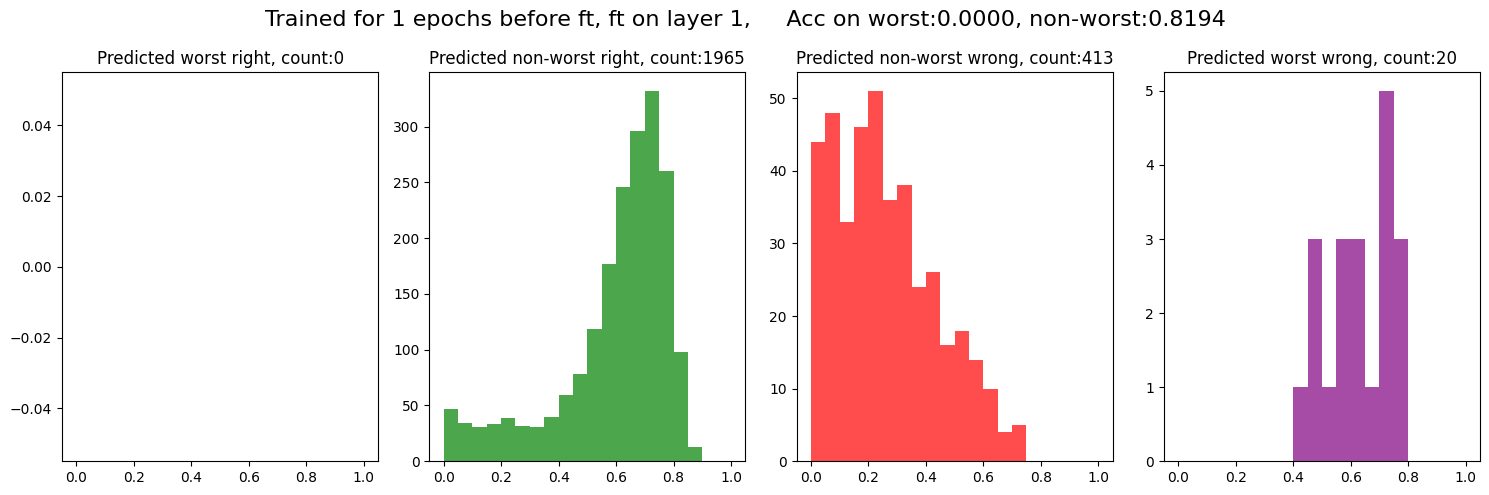

In [20]:
get_margin_hist('waterbirds', epoch=1, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7998


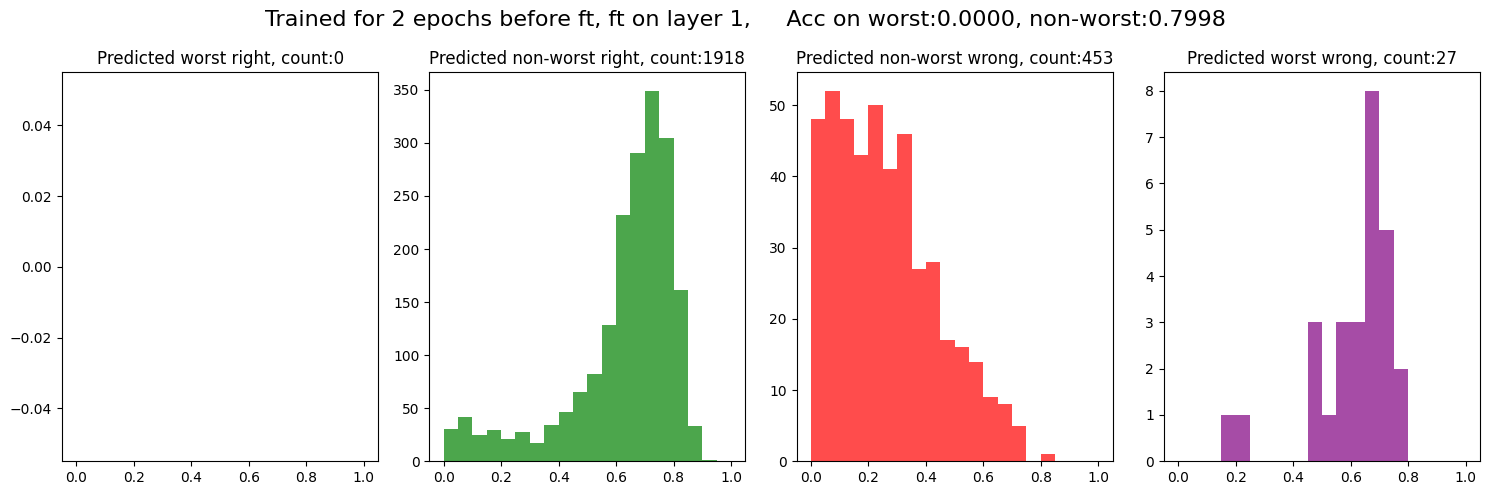

In [21]:
get_margin_hist('waterbirds', epoch=2, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7727


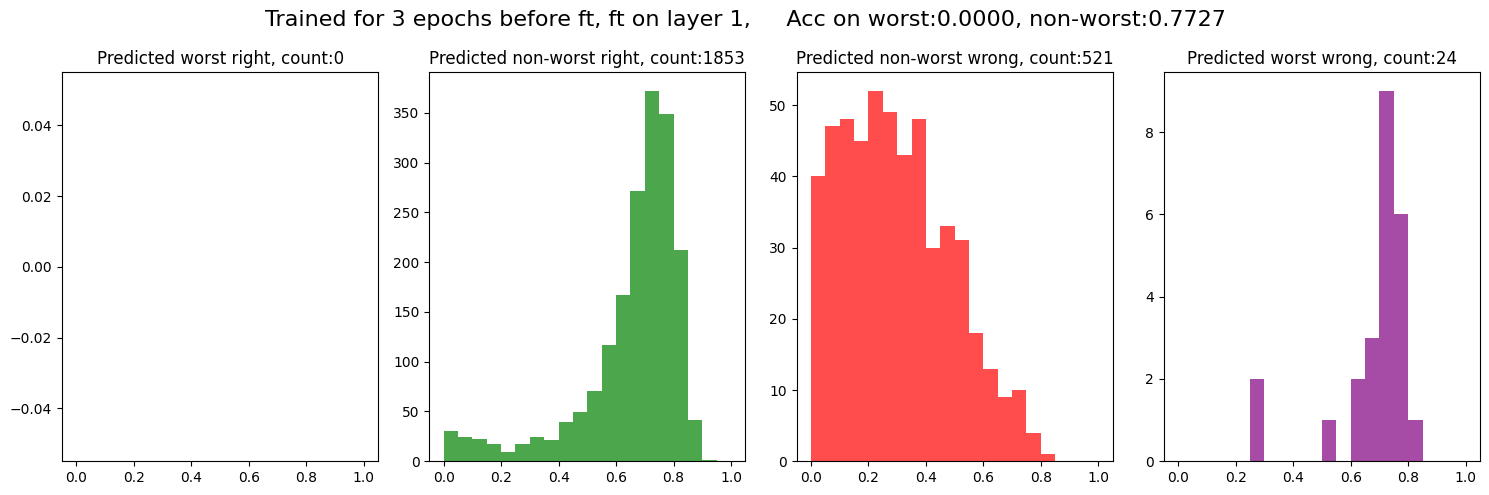

In [22]:
get_margin_hist('waterbirds', epoch=3, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7940


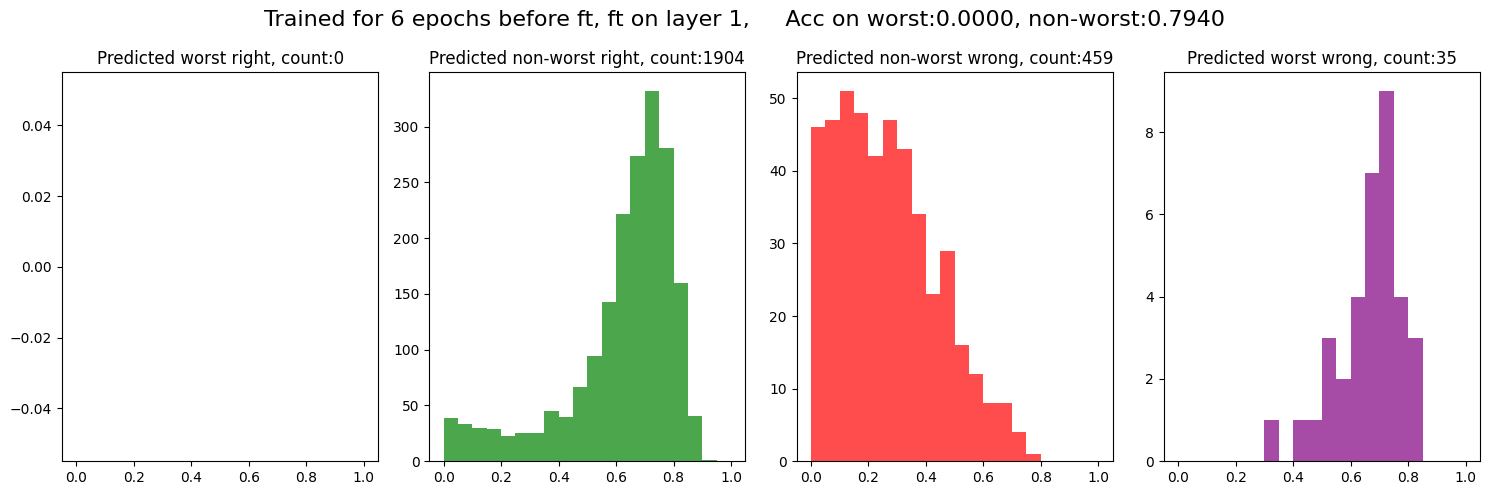

In [23]:
get_margin_hist('waterbirds', epoch=6, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7719


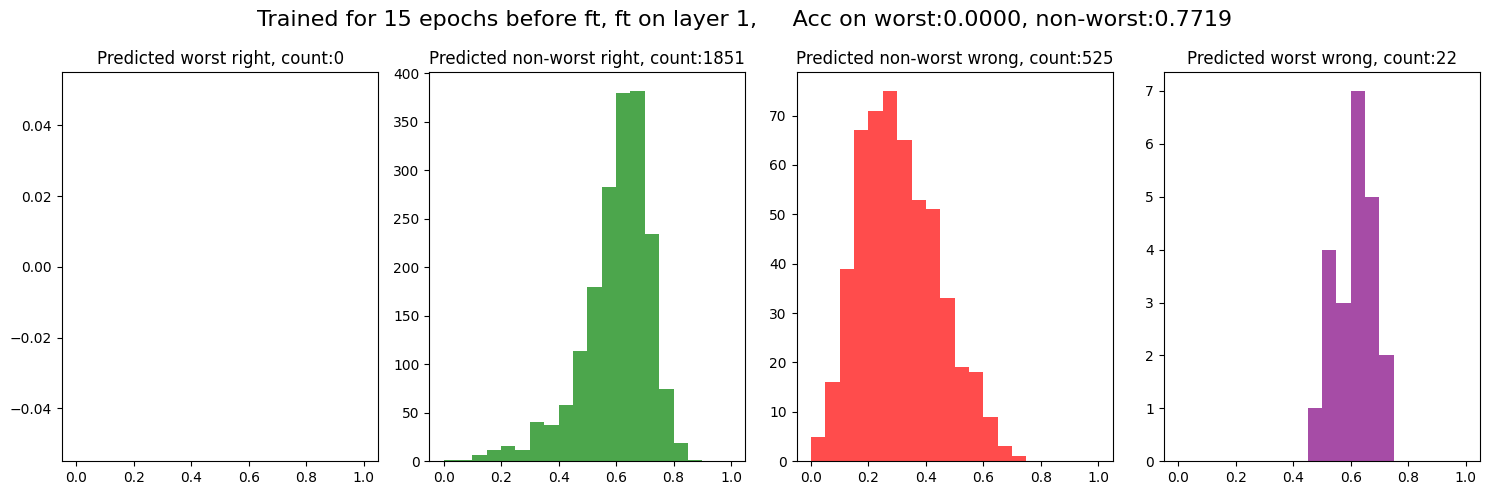

In [26]:
get_margin_hist('waterbirds', epoch=15, feature_level=1, basic_block=False)

In [ ]:
get_margin_hist('waterbirds', epoch=30, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7694


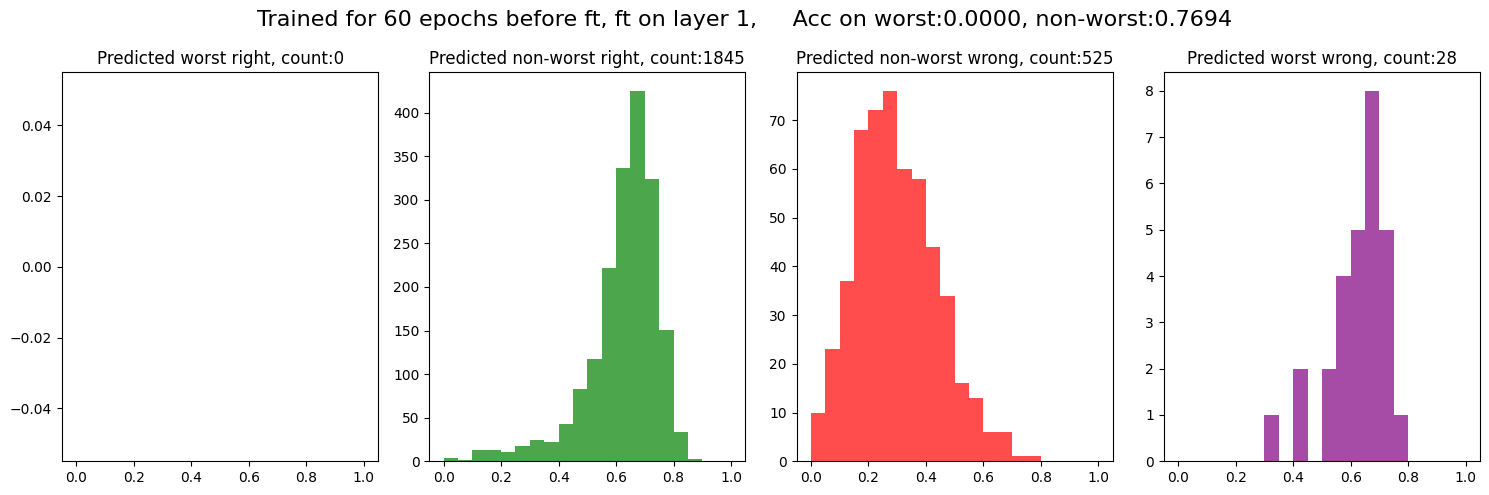

In [27]:
get_margin_hist('waterbirds', epoch=60, feature_level=1, basic_block=False)

In [ ]:
get_margin_hist('waterbirds', epoch=90, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7623


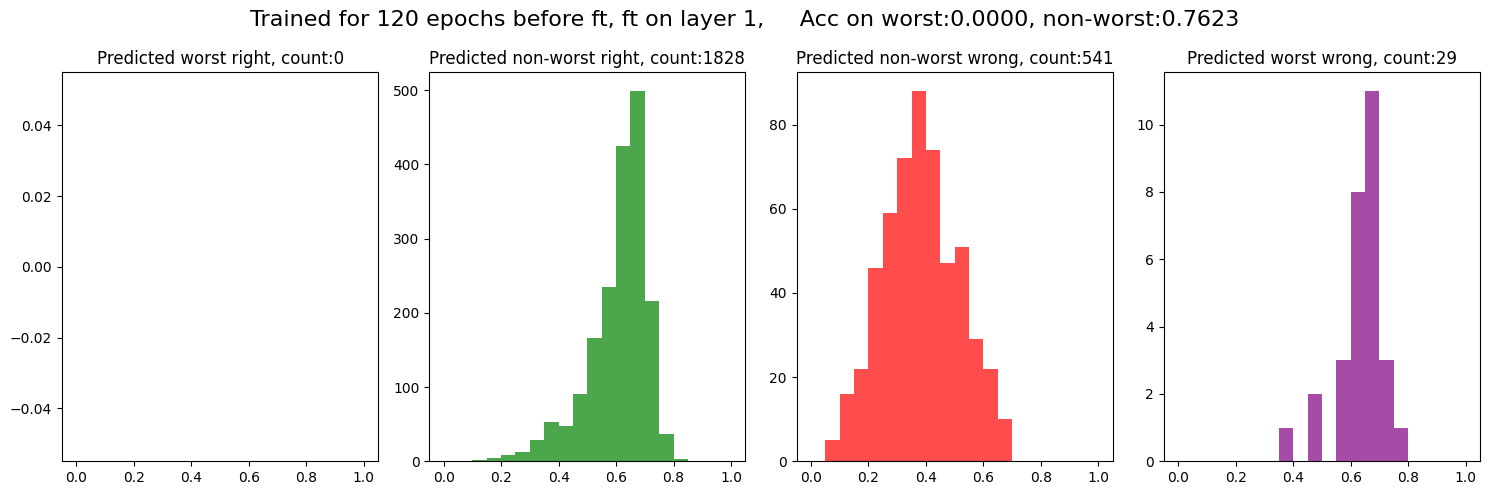

In [28]:
get_margin_hist('waterbirds', epoch=120, feature_level=1, basic_block=False)

In [ ]:
get_margin_hist('waterbirds', epoch=150, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.7548


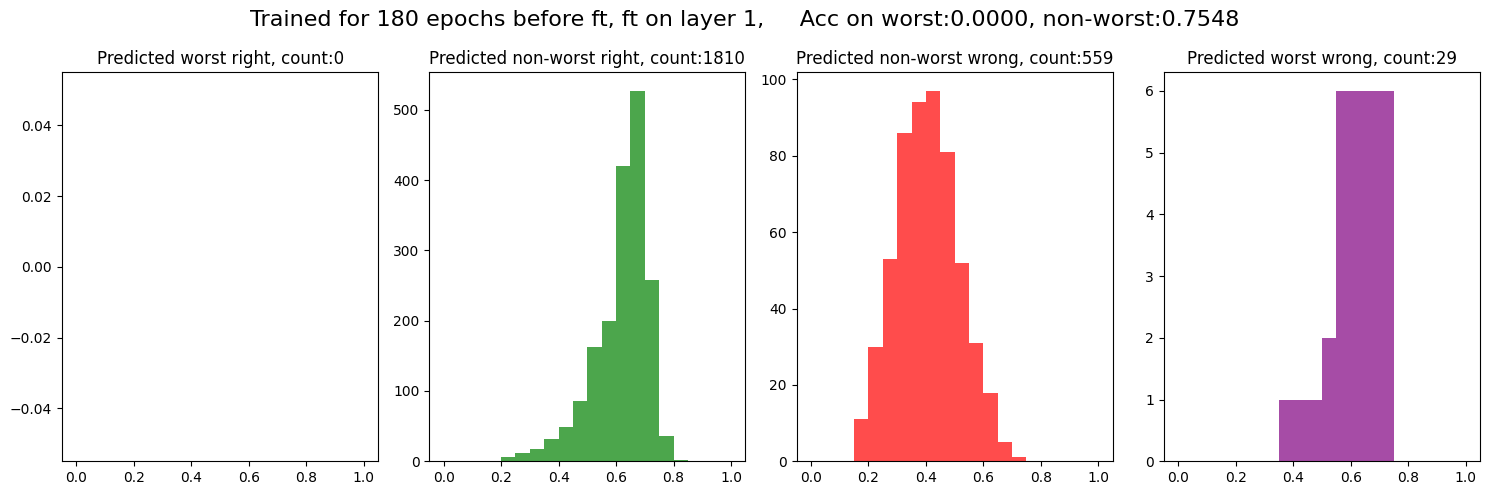

In [29]:
get_margin_hist('waterbirds', epoch=180, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8515


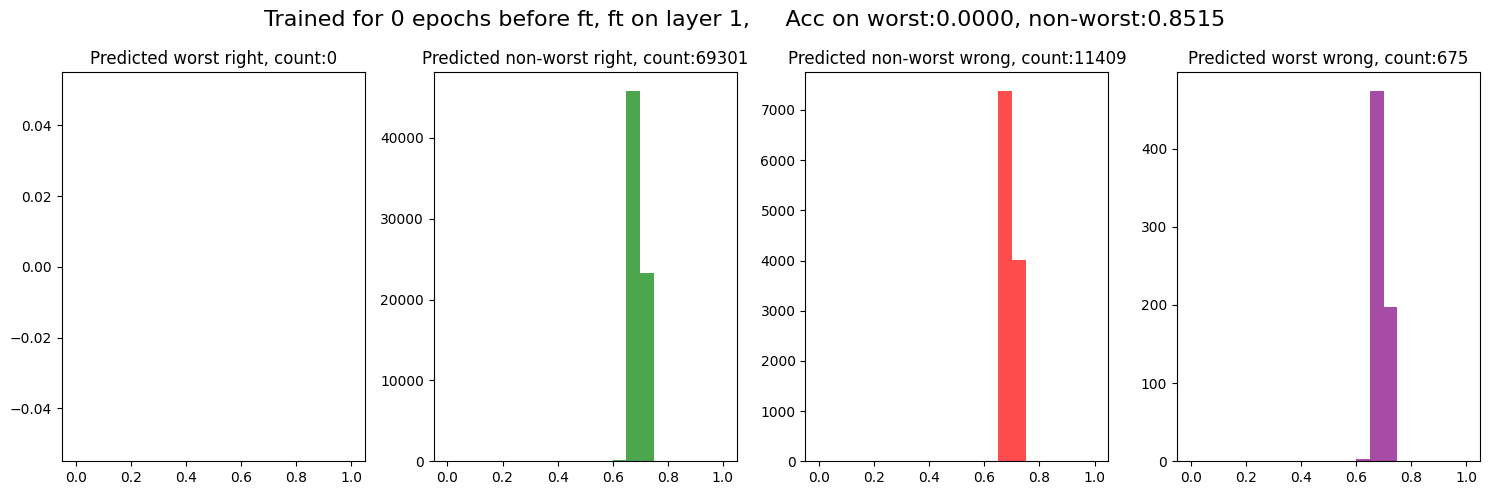

In [30]:
get_margin_hist('CelebA', epoch=0, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8502


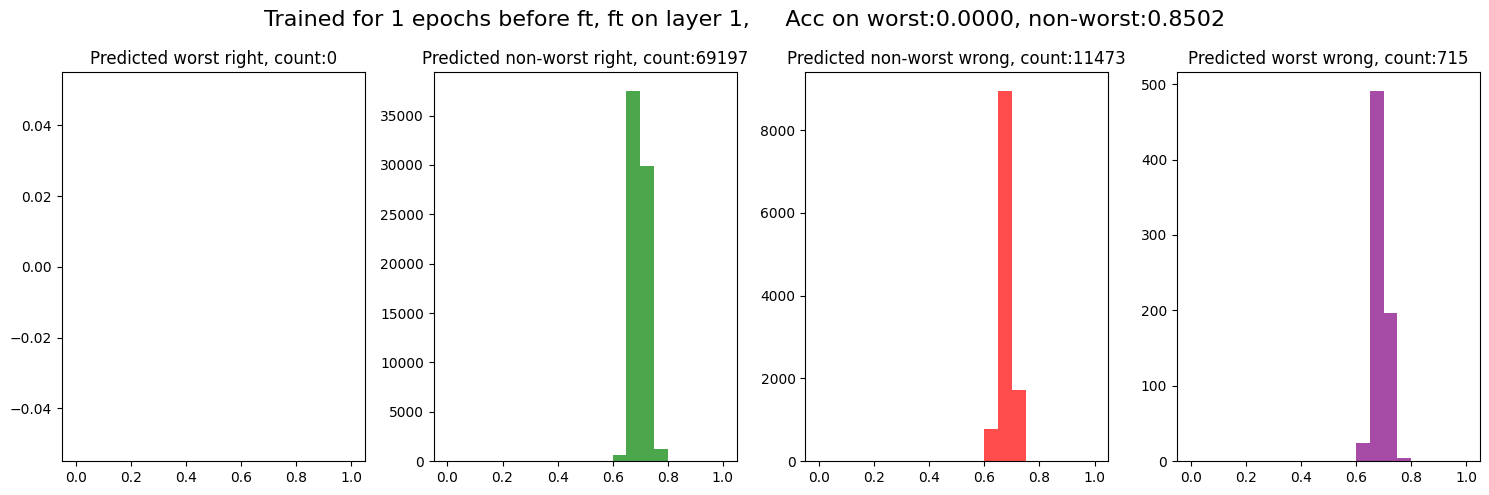

In [31]:
get_margin_hist('CelebA', epoch=1, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8504


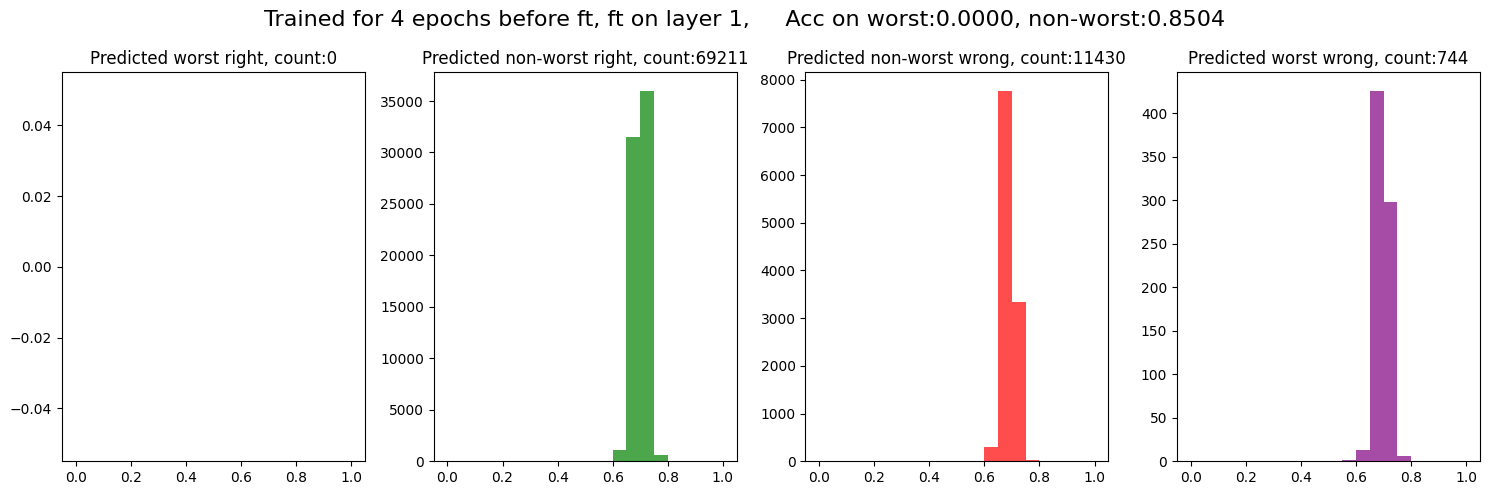

In [32]:
get_margin_hist('CelebA', epoch=4, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8507


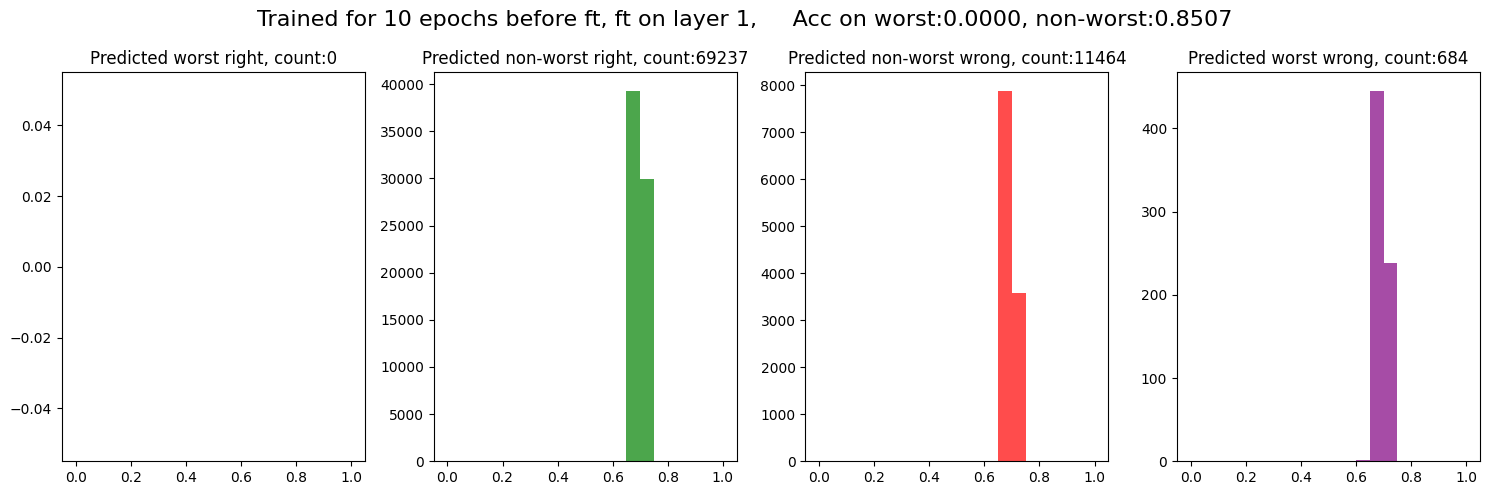

In [33]:
get_margin_hist('CelebA', epoch=10, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8512


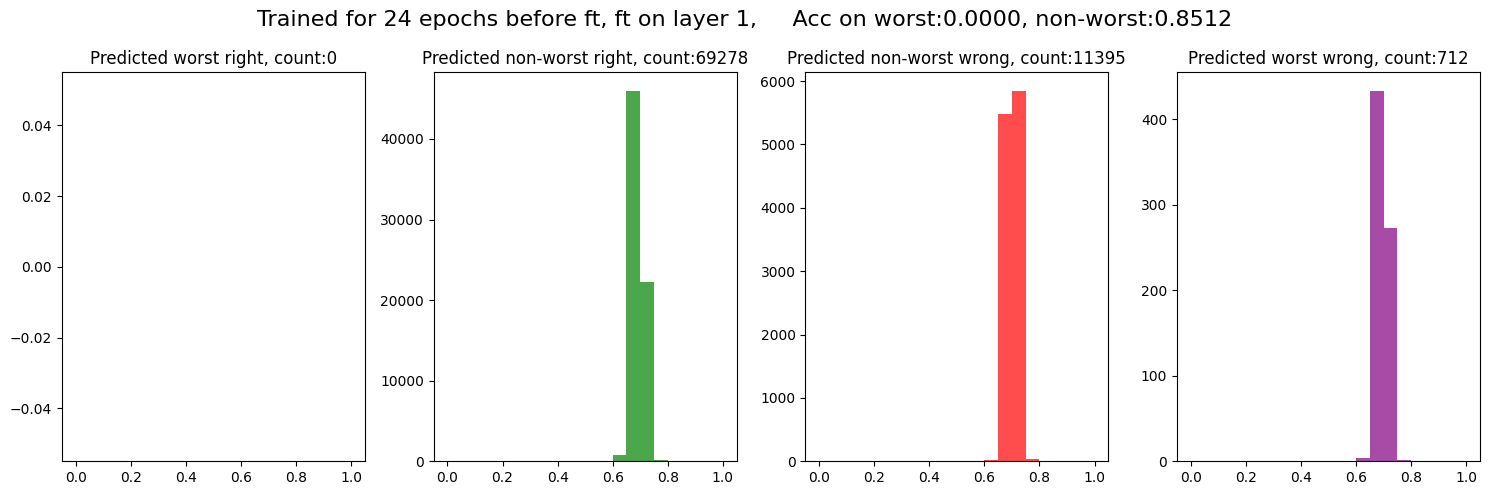

In [34]:
get_margin_hist('CelebA', epoch=24, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8503


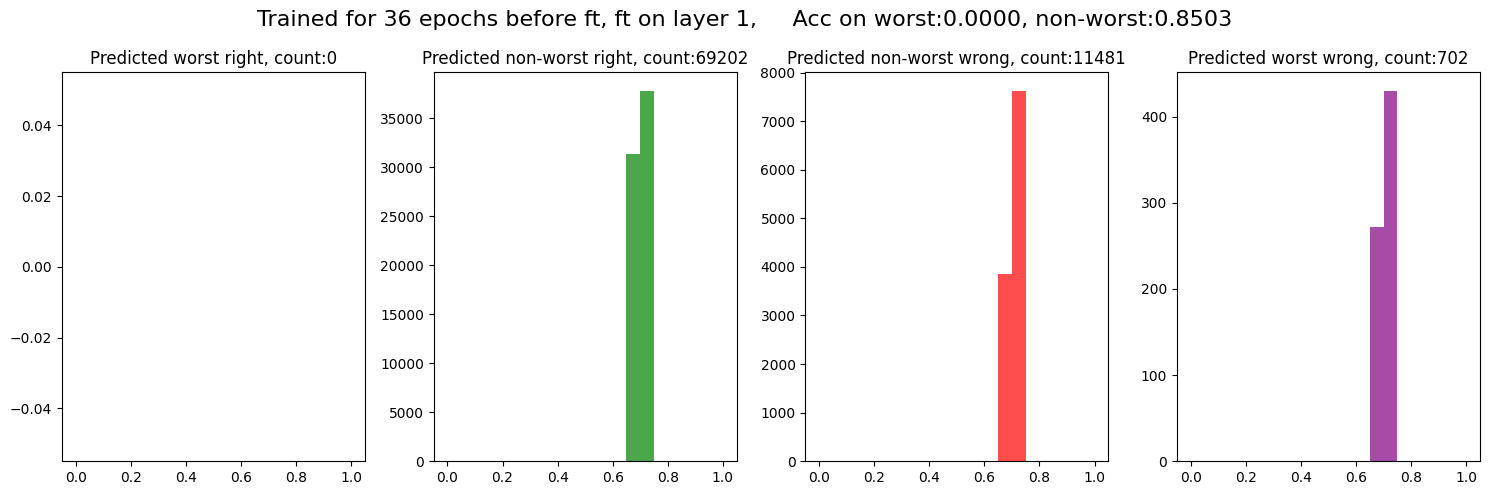

In [35]:
get_margin_hist('CelebA', epoch=36, feature_level=1, basic_block=False)

Fraction of worst predicted right:0.0000
Fraction of non-worst predicted right:0.8496


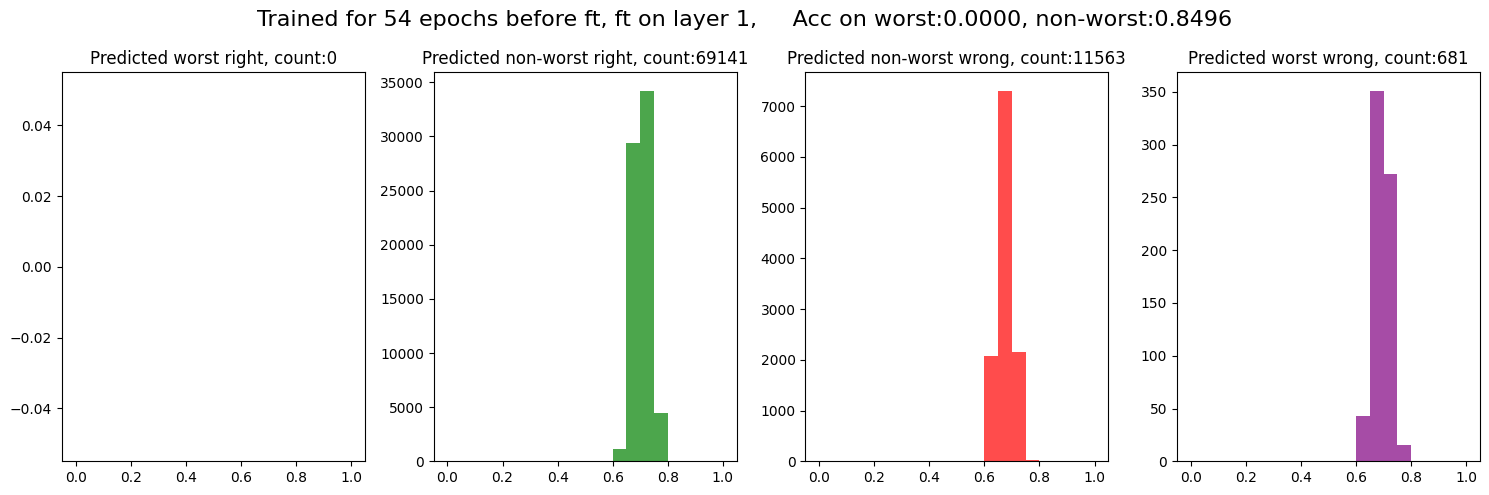

In [36]:
get_margin_hist('CelebA', epoch=54, feature_level=1, basic_block=False)

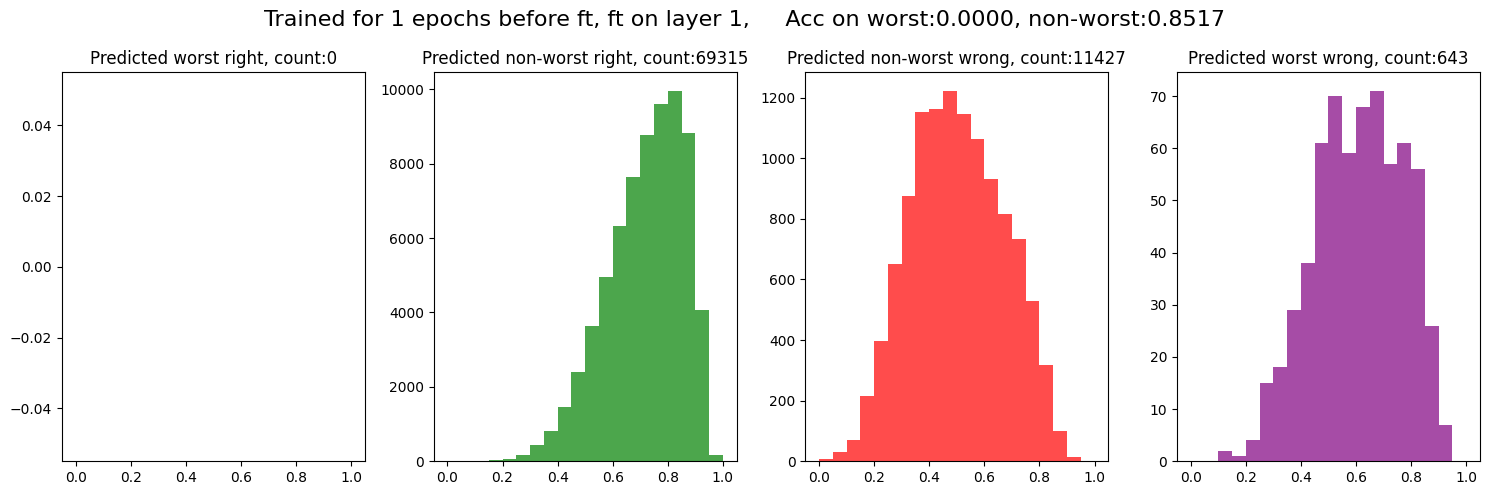

In [40]:
get_margin_hist('CelebA', epoch=1, feature_level=1, basic_block=True)

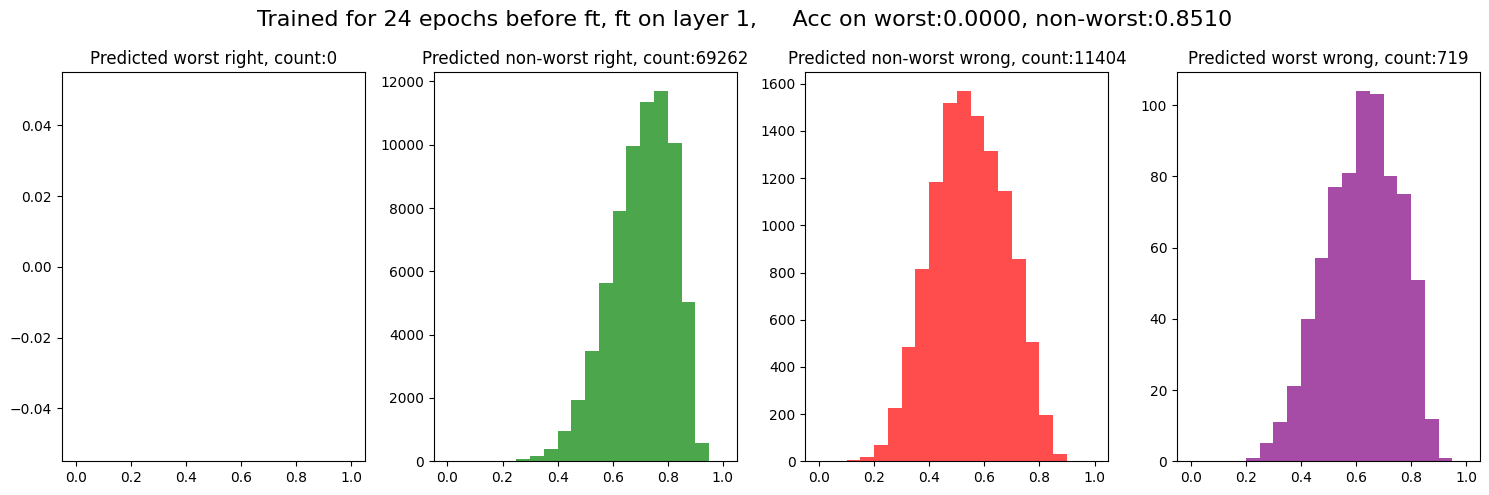

In [41]:
get_margin_hist('CelebA', epoch=24, feature_level=1, basic_block=True)

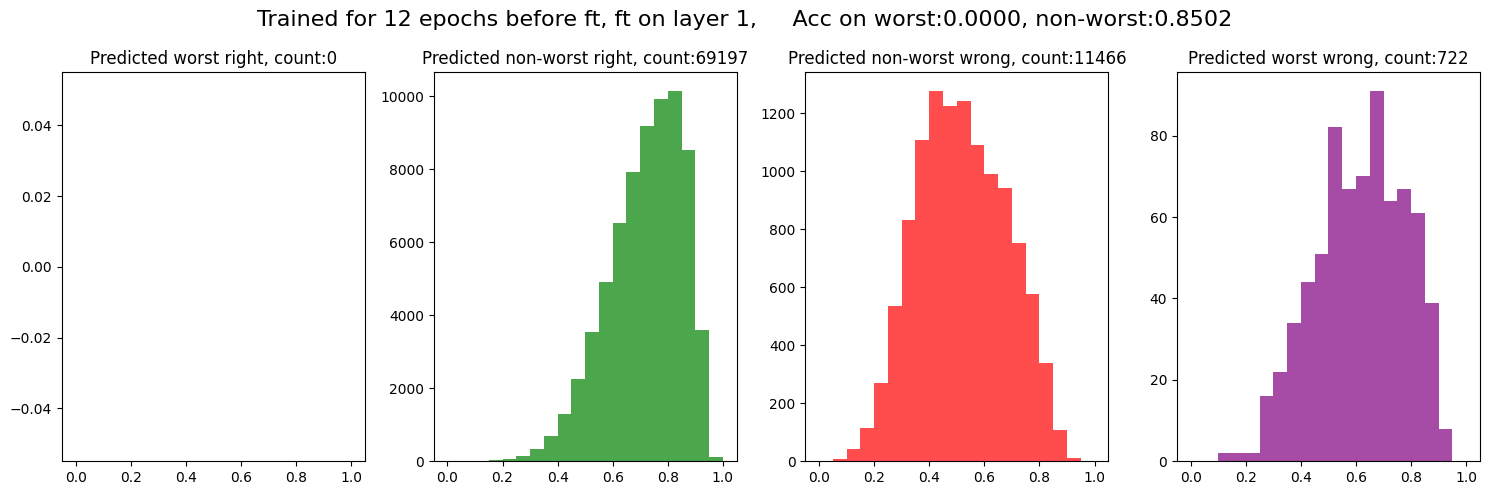

In [42]:
get_margin_hist('CelebA', epoch=12, feature_level=1, basic_block=True)

In [42]:
# print(set(model.state_dict().keys()) - set(model_ckpt['model'].keys()))
print(BasicBlock)

<class '__main__.BasicBlock'>


In [10]:
model = get_model('resnet18')
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(os.path.join(f'./results/CUB/resnet18-pt_0/', f'0_ckpt.pth.tar'))['model'])
learning_rate, widx, epochs = 1e-3, 2, 8

loader_kwargs = {'batch_size':10, 'num_workers':4, 'pin_memory':True}
with open(os.path.join('results', 'CUB', 'waterbird_complete95_forest2water2_dataset_0.pkl'), 'rb') as file:
    data = pickle.load(file)
    train_data = data['train_data']
    train_loader = get_loader(train_data, train=True, **loader_kwargs)
loader_kwargs = {'batch_size':64, 'num_workers':4, 'pin_memory':True}
n = len(train_data)
train_data, test_data = random_split(train_data, [n//2, n-n//2])
train_loader, test_loader = get_loader(train_data, train=True, **loader_kwargs), \
                            get_loader(test_data, train=False, **loader_kwargs)
    
model = model.to(device='cuda')
for _, param in model.named_parameters():
    param.requires_grad = False
feature_level = 2
# converter = model._make_layer(BasicBlock, 64 * 2**feature_level, 0)
converter = BasicBlock(32 * 2**feature_level, 64 * 2**feature_level, stride=1).to(device='cuda')
model = FeatResNet(model, feature_level).to(device='cuda')

samples = next(iter(train_loader))
sample_inputs = samples[0].to(device='cuda')

features = model(sample_inputs)
features = converter(features)
print(converter)
d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
projector = Projector(d, converter).to(device='cuda')
print(projector(model(sample_inputs)).shape)

BasicBlock(
  (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 2])


In [11]:

# d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
# projector = Projector(d).to(device='cuda')
projector.train()

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, projector.parameters()), 
                            lr=learning_rate, momentum=0.9, weight_decay=5e-4)
train(model, projector, optimizer, train_loader, num_epochs=epochs)
# yhat, correct, worst = infer(model, projector, test_loader, widx=widx)